In [1]:
import warnings
import os
import sys
import yaml
import shutil
import logging
import pandas as pd
import numpy as np
import importlib
import tqdm

from pathlib import Path
from argparse import ArgumentParser
from collections import defaultdict

import torch
from mlguess.torch.distributed import distributed_model_wrapper
from mlguess.torch.pbs import launch_script, launch_script_mpi
from mlguess.torch.checkpoint import load_model_state
from mlguess.torch.trainer import Trainer
from mlguess.torch.regression_losses import LipschitzMSELoss
from mlguess.torch.models import seed_everything, DNN
from mlguess.regression_metrics import regression_metrics

from captum.attr import (GradientShap, IntegratedGradients, DeepLift, LayerConductance, 
                         Saliency, InputXGradient, GuidedBackprop, Deconvolution, 
                         FeatureAblation, Occlusion)
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = "cuda"

In [3]:
config = "../fv/model.yml"

In [4]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [5]:
def import_class_from_path(class_name, file_path):
    spec = importlib.util.spec_from_file_location(class_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return getattr(module, class_name)

In [6]:
torch_dataset = import_class_from_path(conf["data"]["dataset_name"], conf["data"]["dataset_path"])

In [7]:
train_dataset = torch_dataset(conf, split="train")
valid_dataset = torch_dataset(conf, split="valid")

In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=conf['trainer']['train_batch_size'],
    shuffle=False,
    pin_memory=True,
    persistent_workers=True,
    num_workers=8,
    drop_last=False
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=conf['trainer']['valid_batch_size'],
    shuffle=False,
    pin_memory=True,
    num_workers=8,
    drop_last=False
)

In [9]:
# from torch import nn
# from torch.nn import init
# import torch
# import logging
# from torch.nn.utils import spectral_norm as SpectralNorm
# import warnings
# import random
# import numpy as np
# import sys
# import os
# from mlguess.torch.checkpoint import load_model_state
# from mlguess.torch.models import LinearNormalGamma, init_weights

# class DNN(nn.Module):
#     def __init__(self,
#                  input_size,
#                  output_size,
#                  layer_size=[1000],
#                  dr=[0.5],
#                  batch_norm=True,
#                  lng=False,
#                  weight_init=False,
#                  num_layers=None):

#         input_size = len(input_size) if isinstance(input_size, (list, tuple)) else input_size
#         output_size = len(output_size) if isinstance(output_size, (list, tuple)) else output_size

#         super(DNN, self).__init__()
#         self.lng = lng

#         if num_layers is not None and isinstance(layer_size, (int, float)):
#             layer_size = [layer_size] * num_layers
#             dr = [dr] * num_layers if isinstance(dr, (int, float)) else dr

#         if len(layer_size) > 0:
#             blocks = self.block(input_size, layer_size[0], dr[0], batch_norm)
#             if len(layer_size) > 1:
#                 for i in range(len(layer_size) - 1):
#                     blocks += self.block(layer_size[i], layer_size[i + 1], dr[i], batch_norm)
#             if lng:
#                 blocks.append(LinearNormalGamma(layer_size[-1], output_size))
#             else:
#                 blocks.append(SpectralNorm(nn.Linear(layer_size[-1], output_size)))
#         else:
#             if lng:
#                 blocks = [LinearNormalGamma(input_size, output_size)]
#             else:
#                 blocks = [SpectralNorm(nn.Linear(input_size, output_size))]

#         self.fcn = nn.Sequential(*blocks)
#         if weight_init:
#             self.apply(self.init_weights)

#     def block(self, input_size, output_size, dr, batch_norm):
#         block = [SpectralNorm(nn.Linear(input_size, output_size))]
#         if batch_norm:
#             block.append(nn.BatchNorm1d(output_size))
#         block.append(nn.LeakyReLU())
#         if dr > 0.0:
#             block.append(nn.Dropout(dr))
#         return block

#     def forward(self, x):
#         x = self.fcn(x)
#         return x

#     def load_weights(self, weights_path: str) -> None:

#         """
#             Loads model weights given a valid weights path

#             weights_path: str
#             - File path to the weights file (.pt)
#         """
#         logger.info(f"Loading model weights from {weights_path}")

#         try:
#             checkpoint = torch.load(
#                 weights_path,
#                 map_location=lambda storage, loc: storage
#             )
#             self.load_state_dict(checkpoint["model_state_dict"])
#         except Exception as E:
#             logger.info(
#                 f"Failed to load model weights at {weights_path} due to error {str(E)}"
#             )

#     def predict(self, input, y_scaler=None, return_uncertainties=True, return_tuple=False):
#         output = self(input)
#         if return_uncertainties:
#             output = self.predict_uncertainty(output, y_scaler=y_scaler)
#         if return_tuple:
#             return output
#         return torch.cat(output, dim=1)

#     def predict_uncertainty(self, input, y_scaler=None):
#         mu, v, alpha, beta = input
#         aleatoric = beta / (alpha - 1)
#         epistemic = beta / (v * (alpha - 1))

#         if len(mu.shape) == 1:
#             mu = mu.unsqueeze(1)
#             aleatoric = aleatoric.unsqueeze(1)
#             epistemic = epistemic.unsqueeze(1)

#         if y_scaler:
#             mu = mu.detach().cpu().numpy()
#             mu = y_scaler.inverse_transform(mu)
#             mu = torch.from_numpy(mu).to(aleatoric.device)

#         # MinMaxScaler inverse transform
#         # if y_scaler:
#         #     min_val = torch.tensor(y_scaler.data_min_, device=mu.device)
#         #     max_val = torch.tensor(y_scaler.data_max_, device=mu.device)
#         #     mu = mu * (max_val - min_val) + min_val

#             for i in range(mu.shape[-1]):
#                 aleatoric[:, i] *= self.training_var[i]
#                 epistemic[:, i] *= self.training_var[i]

#         return mu, aleatoric, epistemic, aleatoric + epistemic

#     def predict_dropout(self, x, mc_forward_passes=10, batch_size=None):
#         _batch_size = self.batch_size if batch_size is None else batch_size
#         y_prob = np.stack(
#             [
#                 np.vstack(
#                     [
#                         self(np.expand_dims(lx, axis=-1), training=True)
#                         for lx in np.array_split(x, x.shape[0] // _batch_size)
#                     ]
#                 )
#                 for _ in range(mc_forward_passes)
#             ]
#         )
#         pred_probs = y_prob.mean(axis=0)
#         epistemic = y_prob.var(axis=0)
#         aleatoric = np.mean(y_prob * (1.0 - y_prob), axis=0)

#         # Calculating entropy across multiple MCD forward passes
#         epsilon = sys.float_info.min
#         entropy = -np.sum(
#             pred_probs * np.log(np.maximum(pred_probs, epsilon)), axis=-1
#         )  # shape (n_samples,)
#         # Calculating mutual information across multiple MCD forward passes
#         mutual_info = entropy - np.mean(
#             np.sum(-np.array(y_prob) * np.log(np.maximum(y_prob, epsilon)), axis=-1), axis=0
#         )  # shape (n_samples,)
#         return pred_probs, aleatoric, epistemic, entropy, mutual_info

#     @classmethod
#     def from_config(cls, conf, device="cpu"):
#         # init the model
#         model = cls(**conf["model"])

#         # load model weights
#         model = load_model_state(conf, model, device)

#         return model


In [10]:
m = DNN(**conf["model"]).to(device)

In [11]:
m.training_var = train_dataset.training_var

In [12]:
m = load_model_state(conf, m, device)

In [13]:
# valid_attributions = interpret_model(m, valid_loader, train_dataset.y_scaler, method='IntegratedGradients')

In [14]:
data_iter = iter(train_loader)
inputs, targets = next(data_iter)
inputs = inputs.to(device)
targets = targets.to(device)

In [15]:
m.predict(inputs)

tensor([[4.0665e-02, 8.4699e-04, 7.1192e-02, 7.2039e-02],
        [5.2291e-02, 4.3085e-04, 6.4503e-02, 6.4934e-02],
        [6.3831e-02, 1.9890e-04, 5.3721e-02, 5.3920e-02],
        ...,
        [2.8870e-01, 9.8171e-04, 3.5215e-01, 3.5313e-01],
        [3.4294e-01, 1.3928e-03, 5.8110e-01, 5.8249e-01],
        [3.3487e-01, 1.1730e-03, 5.3627e-01, 5.3744e-01]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [16]:
explainer = GradientShap(m.predict) # (lambda x: predict_uncertainty_output(x, model, scaler))

In [17]:
baselines = torch.zeros_like(inputs).to(device)

In [18]:
attributions = explainer.attribute(inputs, baselines, target=0)#, target=targets)

In [19]:
attributions

tensor([[-0.0700, -0.0318,  0.0171, -0.0025],
        [-0.0640, -0.0362,  0.0194, -0.0008],
        [-0.0532, -0.0326,  0.0174, -0.0007],
        ...,
        [ 0.1624,  0.0338, -0.0215, -0.0028],
        [ 0.1882,  0.0375, -0.0269, -0.0045],
        [ 0.1899,  0.0319, -0.0214, -0.0063]], device='cuda:0')

In [20]:
def visualize_attributions(attributions, feature_names=None):
    # Convert attributions to numpy array if it is a tensor
    if isinstance(attributions, torch.Tensor):
        attributions = attributions.cpu().detach().numpy()
    
    # Assume attributions for a single example (shape: [num_features])
    if attributions.ndim == 2:
        attributions = attributions[0]
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(attributions))]
    
    # Plot attributions
    plt.figure(figsize=(10, 5))
    plt.barh(np.arange(len(attributions)), attributions, align='center')
    plt.yticks(np.arange(len(attributions)), feature_names)
    plt.xlabel('Attribution')
    plt.title('Feature Attributions')
    plt.show()
    
def visualize_average_attributions(attributions, feature_names=None):
    # Convert attributions to numpy array if it is a tensor
    if isinstance(attributions, torch.Tensor):
        attributions = attributions.cpu().detach().numpy()
    
    # Compute the average attributions across the batch
    avg_attributions = np.mean(attributions, axis=0)
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(avg_attributions))]
    
    # Plot average attributions
    plt.figure(figsize=(10, 5))
    plt.barh(np.arange(len(avg_attributions)), avg_attributions, align='center')
    plt.yticks(np.arange(len(avg_attributions)), feature_names)
    plt.xlabel('Average Attribution')
    plt.title('Average Feature Attributions')
    plt.show()

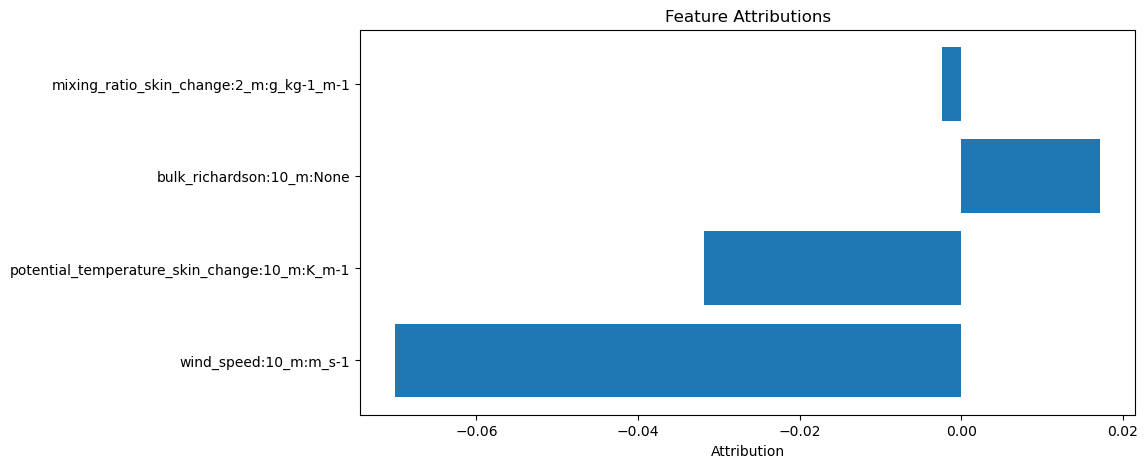

In [21]:
single_attribution = attributions[0]
visualize_attributions(single_attribution, conf['data']['input_cols'])

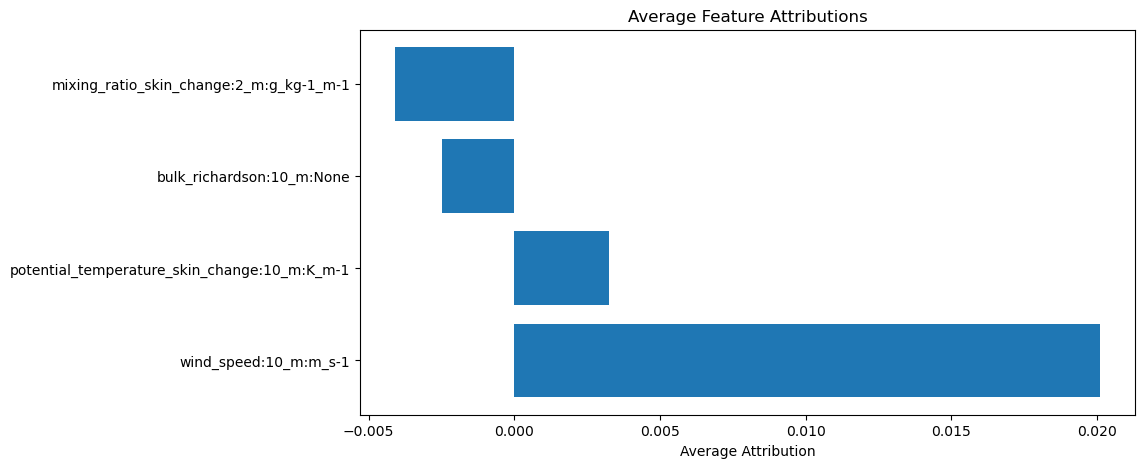

In [22]:
# Example usage:
# Assuming attributions is the output from interpret_model function
# For average attributions across a batch
visualize_average_attributions(attributions, conf['data']['input_cols'])

In [24]:
import torch
from captum.attr import GradientShap, IntegratedGradients, DeepLift, LayerConductance
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


def get_last_linear_layer(sequential_module):
    for layer in reversed(sequential_module):
        if isinstance(layer, torch.nn.Linear):
            return layer
    return None

class ModelWrapper(torch.nn.Module):
    def __init__(self, model, custom_method):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.custom_method = custom_method

    def forward(self, *args, **kwargs):
        return self.custom_method(*args, **kwargs)

class AttributionMethods:
    def __init__(self, model, train_loader, test_loader, num_outputs=4, y_scaler=None, training_var=None, apply_transforms=True, input_columns=None, device="cpu"):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_outputs = num_outputs
        self.y_scaler = y_scaler
        self.training_var = training_var
        self.apply_transforms = apply_transforms
        self.device = device

        # Wrap the model to use the custom predict method in the forward pass
        self.wrapped_model = ModelWrapper(model, model.predict)

        # Initialize explainers
        last_linear_layer = get_last_linear_layer(model.fcn)
        # self.explainers = {
        #     'GradientShap': GradientShap(lambda x: model.predict(x)),
        #     'IntegratedGradients': IntegratedGradients(lambda x: model.predict(x)),
        #     'DeepLift': DeepLift(self.wrapped_model),
        #     'LayerConductance': LayerConductance(self.wrapped_model, last_linear_layer)  # Replace 'model.layer' with the specific layer you want to analyze
        # }
        self.explainers = {
            'GradientShap': GradientShap(self.wrapped_model),
            'IntegratedGradients': IntegratedGradients(self.wrapped_model),
            'DeepLift': DeepLift(self.wrapped_model),
            'LayerConductance': LayerConductance(self.wrapped_model, last_linear_layer),
            'Saliency': Saliency(self.wrapped_model),
            'InputXGradient': InputXGradient(self.wrapped_model),
            'GuidedBackprop': GuidedBackprop(self.wrapped_model),
            'Deconvolution': Deconvolution(self.wrapped_model),
            'FeatureAblation': FeatureAblation(self.wrapped_model),
            'Occlusion': Occlusion(self.wrapped_model)
        }

        # Use a subset of the training data as baselines
        self.baselines = self._get_baselines()

    def _get_baselines(self):
        baseline_samples = []
        for inputs, _ in self.train_loader:
            baseline_samples.append(inputs)
            if len(baseline_samples) >= 100:
                break
        return torch.cat(baseline_samples).to(self.device)

    # def compute_attributions(self, method='GradientShap'):
    #     explainer = self.explainers[method]
    #     all_attributions = []
    #     for inputs, targets in tqdm.tqdm(self.test_loader, total=len(self.test_loader)):
    #         inputs = inputs.to(self.device)
    #         targets = targets.to(self.device)

    #         batch_attributions = []
    #         for i in range(self.num_outputs):
    #             attr = explainer.attribute(inputs, self.baselines, target=i)
    #             if self.apply_transforms:
    #                 if self.y_scaler is not None and i == 0:
    #                     attr = self.y_scaler.inverse_transform(attr.cpu().detach().numpy())
    #                 elif self.training_var is not None:
    #                     attr *= self.training_var
    #             batch_attributions.append(torch.tensor(attr).to(self.device))
            
    #         all_attributions.append(batch_attributions)
        
    #     return all_attributions

    def compute_attributions(self, method='GradientShap'):
        explainer = self.explainers[method]
        all_attributions = []
        for inputs, targets in tqdm.tqdm(self.test_loader, total=len(self.test_loader)):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            if method != 'GradientShap':
                # Sample baselines to match input size
                num_samples = inputs.shape[0]
                sampled_indices = np.random.choice(len(self.baselines), num_samples, replace=False)
                baselines_sample = self.baselines[sampled_indices].to(self.device)
            else:
                baselines_sample = self.baselines
    
            batch_attributions = []
            for i in range(self.num_outputs):
                if method in ['Saliency', 'InputXGradient', 'GuidedBackprop', 'Deconvolution']:
                    attr = explainer.attribute(inputs, target=i)
                elif method == 'Occlusion':
                    # Example sliding window size of (3, 3, 3) for each input tensor
                    sliding_window_shape = tuple([3] * len(inputs.shape[1:]))
                    attr = explainer.attribute(inputs, sliding_window_shapes=sliding_window_shape)
                else:
                    attr = explainer.attribute(inputs, baselines_sample, target=i)
                if self.apply_transforms:
                    if self.y_scaler is not None and i == 0:
                        attr = self.y_scaler.inverse_transform(attr.cpu().detach().numpy())
                    elif self.training_var is not None:
                        attr *= self.training_var
                batch_attributions.append(torch.tensor(attr).to(self.device))
    
            all_attributions.append(batch_attributions)
        
        return all_attributions


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_attributions(attributions, idx, feature_names=None):
    # Assume attributions is a list of lists: [batch_size][num_outputs][num_features]
    # Flatten the list to get attributions for a single example
    attributions = attributions[idx]  # Take the specified batch for visualization
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(attributions[0]))]
    
    # Plot attributions for each output
    num_outputs = len(attributions)
    fig, axes = plt.subplots(1, num_outputs, figsize=(15, 5))
    for i in range(num_outputs):
        attr = attributions[i].cpu().detach().numpy()  # Ensure the tensor is on the CPU and convert to numpy
        axes[i].barh(np.arange(len(attr)), attr, align='center', color='skyblue', edgecolor='black')
        axes[i].set_yticks(np.arange(len(attr)))
        axes[i].set_yticklabels(feature_names, fontsize=12)
        axes[i].set_xlabel('Attribution', fontsize=14)
        axes[i].set_title(f'Output {i} Attributions', fontsize=16)
        axes[i].grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def visualize_average_attributions(attributions, feature_names=None, output_names = [r'$\mu$', r'$\sigma_{ale}$', r'$\sigma_{epi}$', r'$\sigma_{tot}$']):
    # Assume attributions is a list of lists: [batch_size][num_outputs][num_features]
    # Convert the list of lists to a numpy array for easier manipulation
    all_attributions = []
    for batch in attributions:
        batch_attributions = []
        for output in batch:
            batch_attributions.append(output.cpu().detach().numpy())  # Ensure the tensor is on the CPU and convert to numpy
        all_attributions.append(batch_attributions)
    
    # Concatenate all attributions along the batch dimension
    all_attributions = [np.concatenate([attr[i] for attr in all_attributions], axis=0) for i in range(len(all_attributions[0]))]
    
    # Compute the average attributions across the batch
    avg_attributions = [np.mean(attr, axis=0) for attr in all_attributions]
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(avg_attributions[0].shape[1])]
    
    # Plot average attributions for each output
    num_outputs = len(avg_attributions)
    fig, axes = plt.subplots(1, num_outputs, figsize=(15, 5), sharey="row")
    for i in range(num_outputs):
        axes[i].barh(np.arange(len(avg_attributions[i])), avg_attributions[i], align='center', color='skyblue', edgecolor='black')
        axes[i].set_yticks(np.arange(len(avg_attributions[i])))
        axes[i].set_yticklabels([x.split(":")[0] for x in feature_names], fontsize=12)
        axes[i].set_xlabel('Average Attribution', fontsize=14)
        axes[i].set_title(f'{output_names[i]}', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'))
    plt.tight_layout()
    plt.show()

def plot_time_series(attributions, output_labels):
    time_steps = len(attributions)
    fig, axes = plt.subplots(len(attributions[0]), 1, figsize=(15, 5 * len(attributions[0])))
    for i in range(len(attributions[0])):
        time_series = [torch.abs(attr[i]).mean().cpu().detach().numpy() for attr in attributions]  # Ensure the tensor is on the CPU and convert to numpy
        axes[i].plot(range(time_steps), time_series)
        axes[i].set_title(f'{output_labels[i]} Attributions Over Time')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Mean Absolute Attribution')
    plt.show()


In [26]:
# Initialize the AttributionMethods class
attrib_methods = AttributionMethods(
    m,
    train_loader,
    valid_loader,
    y_scaler = train_loader.dataset.y_scaler,
    training_var = train_loader.dataset.training_var[0],
    device = device
)

In [27]:
# Compute attributions using a specific method
shap_attributions = attrib_methods.compute_attributions(method='GradientShap')

100%|██████████| 19/19 [00:22<00:00,  1.18s/it]


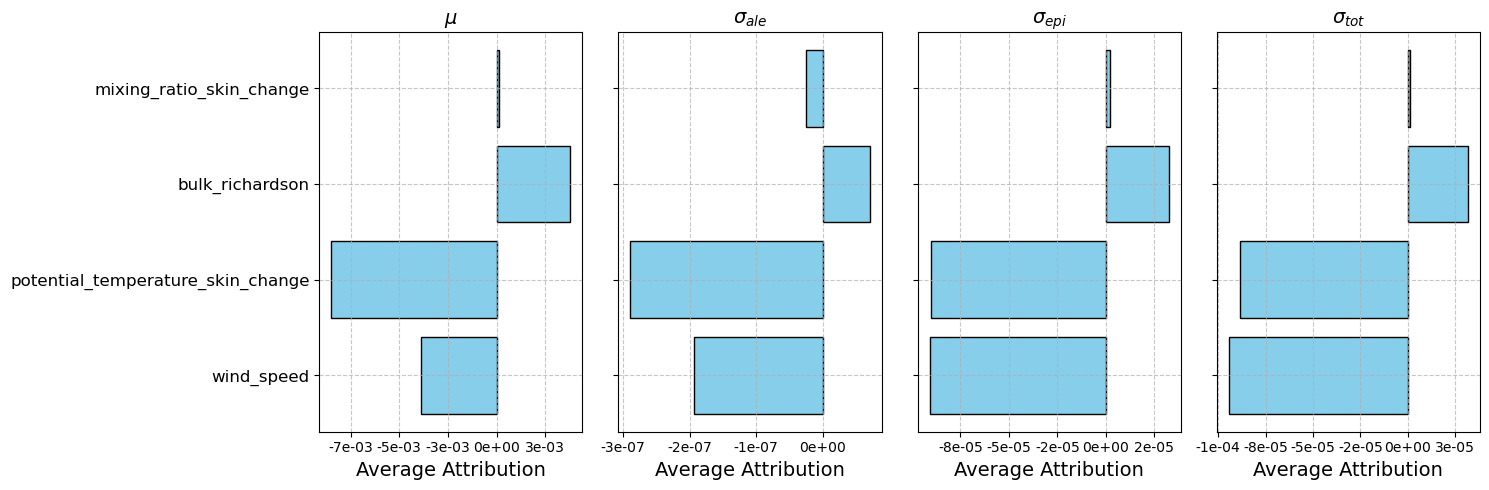

In [28]:
visualize_average_attributions(shap_attributions, conf['data']['input_cols'])

In [29]:
ig_attributions = attrib_methods.compute_attributions(method='IntegratedGradients')

100%|██████████| 19/19 [03:37<00:00, 11.46s/it]


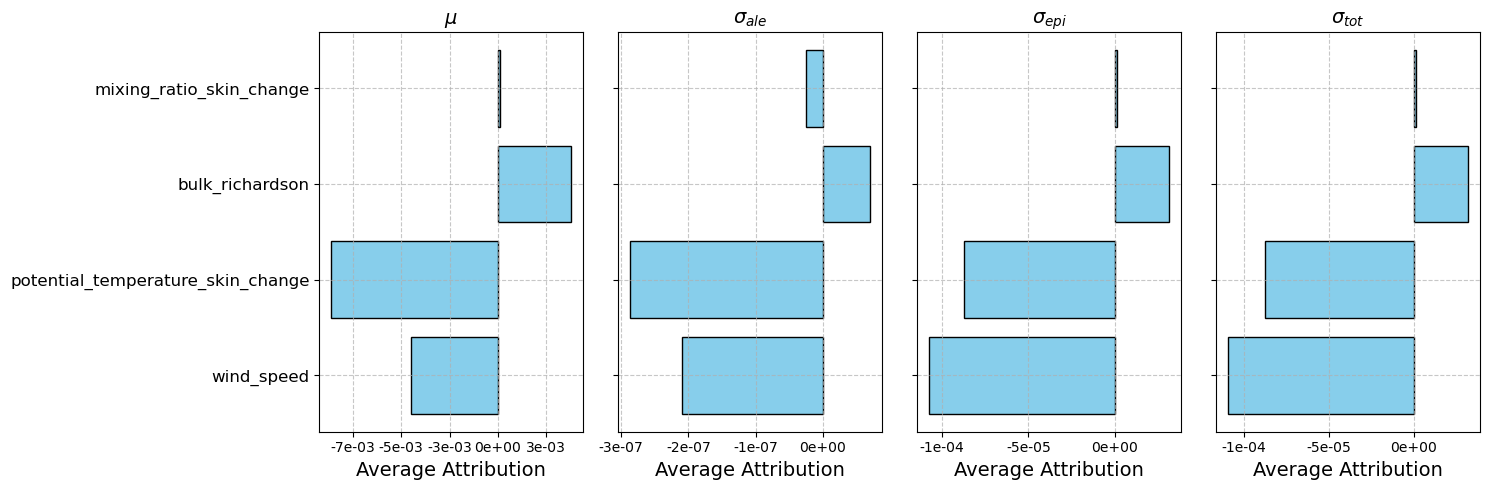

In [30]:
visualize_average_attributions(ig_attributions, conf['data']['input_cols'])

In [31]:
dl_attributions = attrib_methods.compute_attributions(method='DeepLift')

100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


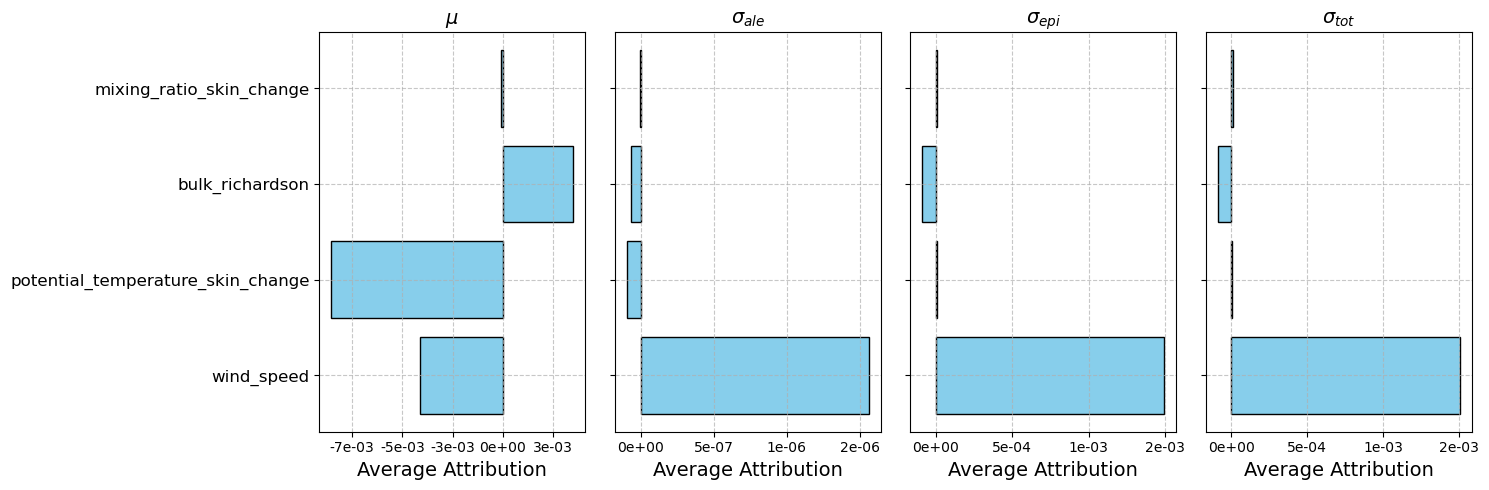

In [32]:
visualize_average_attributions(dl_attributions, conf['data']['input_cols'])

In [33]:
conductance_attr = attrib_methods.compute_attributions(method='LayerConductance')

100%|██████████| 19/19 [03:42<00:00, 11.69s/it]


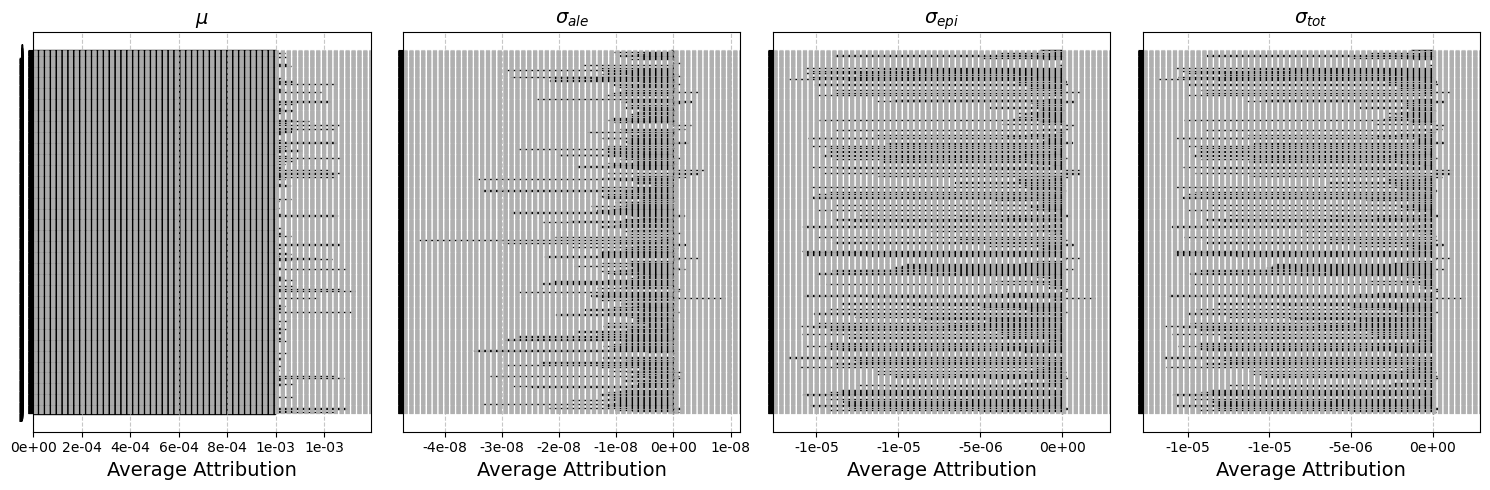

In [34]:
visualize_average_attributions(conductance_attr, [f"j:j" for j in range(1057)])

In [35]:
saliency_attr = attrib_methods.compute_attributions(method='Saliency')

100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


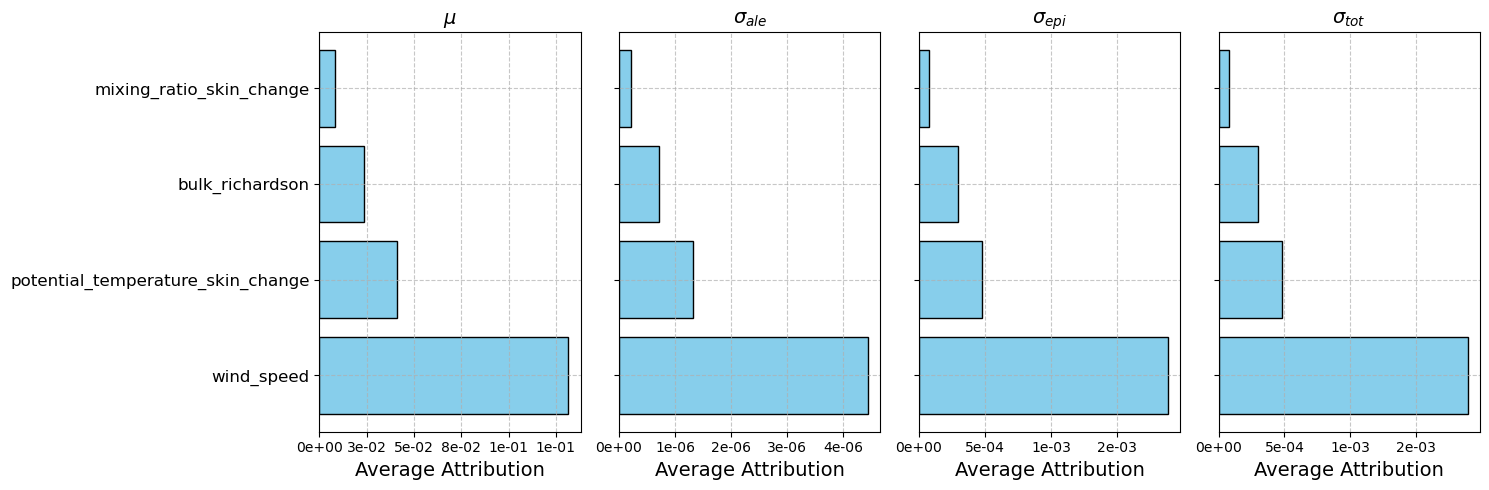

In [36]:
visualize_average_attributions(saliency_attr, conf['data']['input_cols'])

In [37]:
inputxgrad_attr = attrib_methods.compute_attributions(method='InputXGradient')

100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


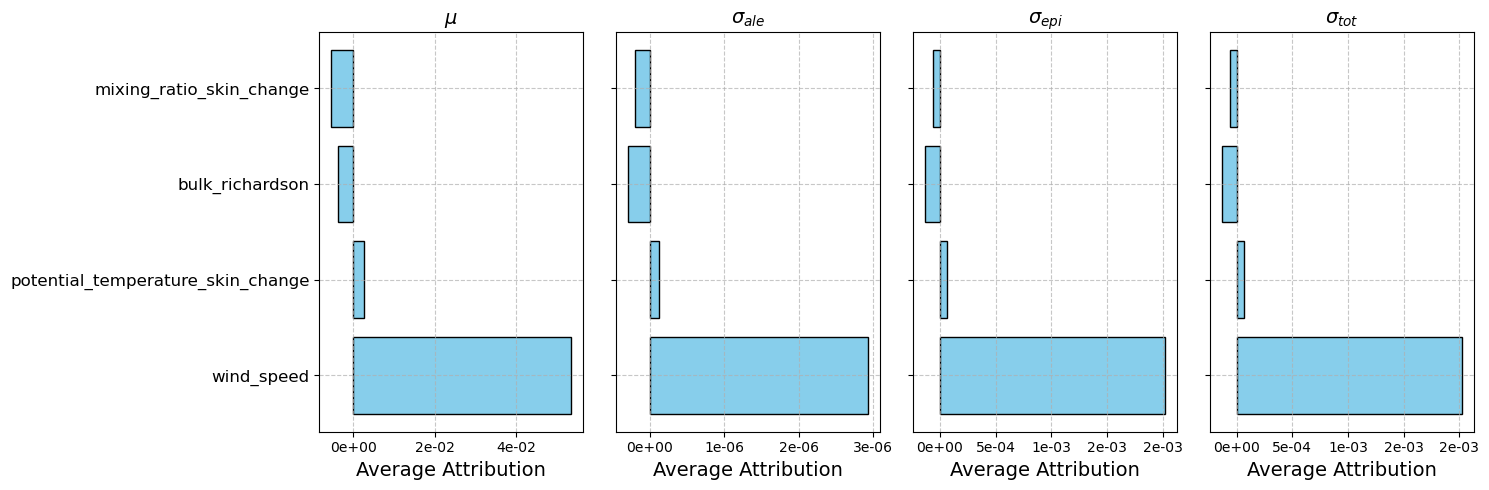

In [38]:
visualize_average_attributions(inputxgrad_attr, conf['data']['input_cols'])

In [39]:
guided_backprop_attr = attrib_methods.compute_attributions(method='GuidedBackprop')

100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


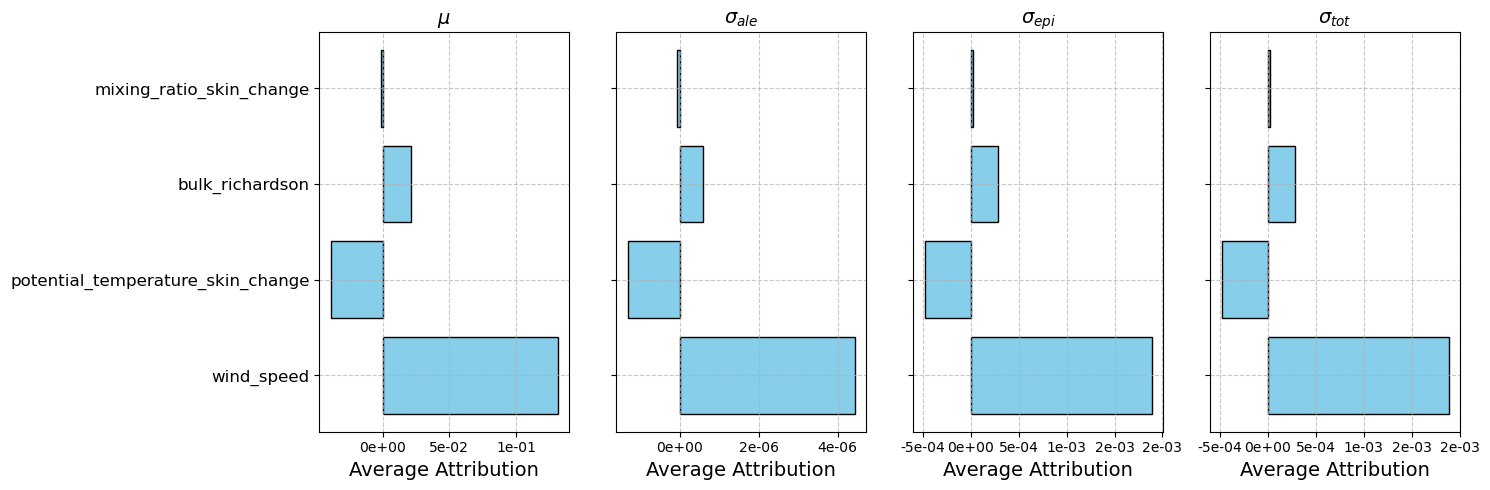

In [40]:
visualize_average_attributions(guided_backprop_attr, conf['data']['input_cols'])

In [41]:
deconv_attr = attrib_methods.compute_attributions(method='Deconvolution')

100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


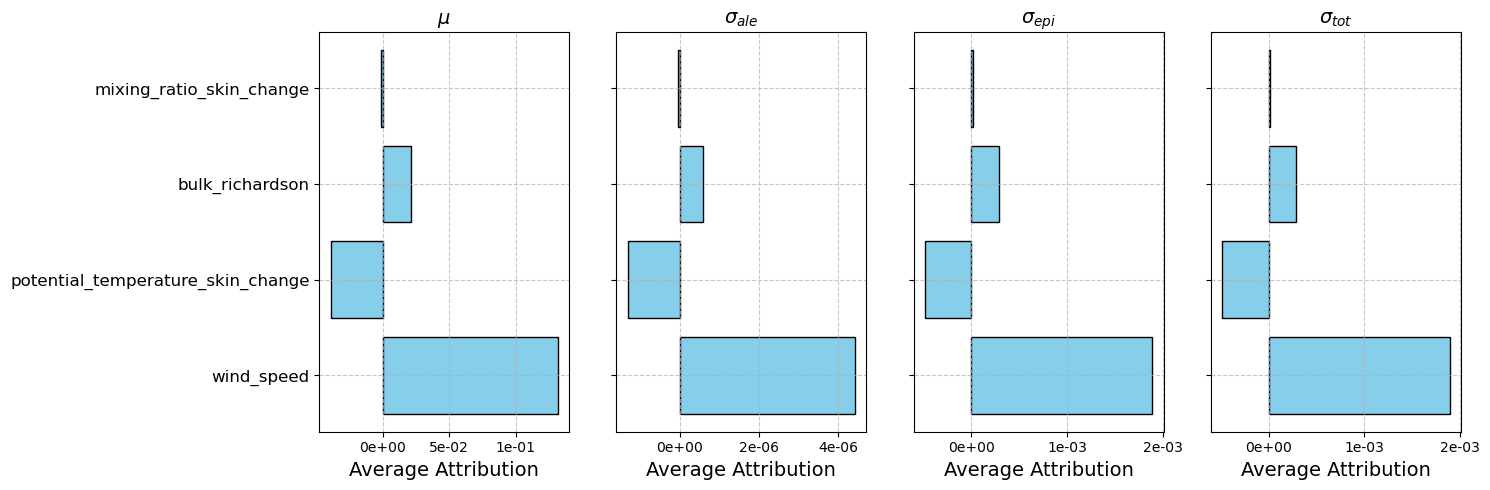

In [42]:
visualize_average_attributions(deconv_attr, conf['data']['input_cols'])

In [43]:
ablation_attr = attrib_methods.compute_attributions(method='FeatureAblation')

100%|██████████| 19/19 [00:02<00:00,  7.48it/s]


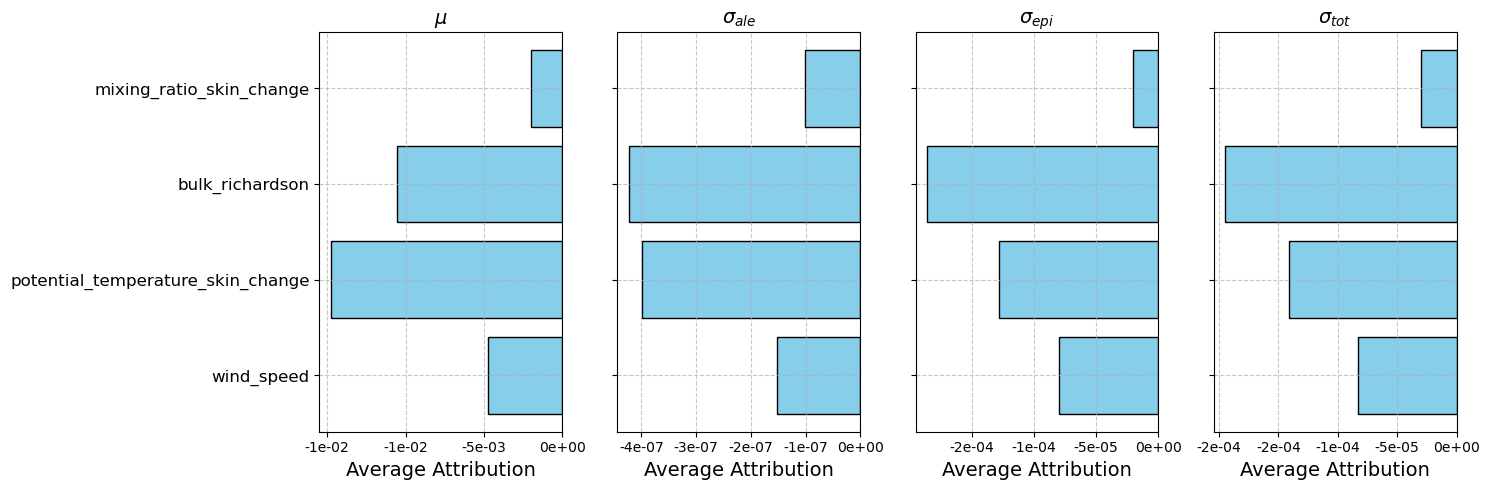

In [44]:
visualize_average_attributions(ablation_attr, conf['data']['input_cols'])

In [45]:
occlusion_attr = attrib_methods.compute_attributions(method= 'Occlusion')

100%|██████████| 19/19 [00:01<00:00,  9.95it/s]


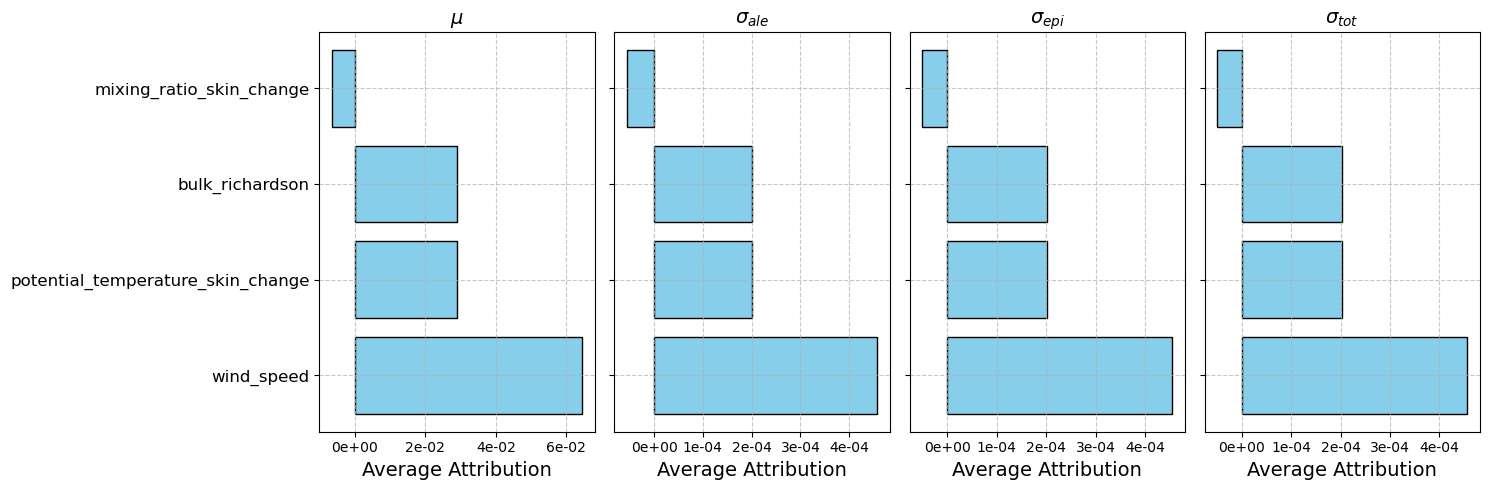

In [46]:
visualize_average_attributions(occlusion_attr, conf['data']['input_cols'])

In [47]:
def get_average_attributions(attributions, feature_names=None, output_names = [r'$\mu$', r'$\sigma_{ale}$', r'$\sigma_{epi}$', r'$\sigma_{tot}$']):
    # Assume attributions is a list of lists: [batch_size][num_outputs][num_features]
    # Convert the list of lists to a numpy array for easier manipulation
    all_attributions = []
    for batch in attributions:
        batch_attributions = []
        for output in batch:
            batch_attributions.append(output.cpu().detach().numpy())  # Ensure the tensor is on the CPU and convert to numpy
        all_attributions.append(batch_attributions)
    
    # Concatenate all attributions along the batch dimension
    all_attributions = [np.concatenate([attr[i] for attr in all_attributions], axis=0) for i in range(len(all_attributions[0]))]
    
    # Compute the average attributions across the batch
    avg_attributions = [np.mean(attr, axis=0) for attr in all_attributions]
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(avg_attributions[0].shape[1])]
    
    # Prepare the result dictionary
    result = {}
    num_outputs = len(avg_attributions)
    for i in range(num_outputs):
        result[feature_names[i]] = avg_attributions[i]
    
    return result

def visualize_average_attributions(attributions, feature_names=None, output_names = [r'$\mu$', r'$\sigma_{ale}$', r'$\sigma_{epi}$', r'$\sigma_{tot}$']):
    # Assume attributions is a list of lists: [batch_size][num_outputs][num_features]
    # Convert the list of lists to a numpy array for easier manipulation
    all_attributions = []
    for batch in attributions:
        batch_attributions = []
        for output in batch:
            batch_attributions.append(output.cpu().detach().numpy())  # Ensure the tensor is on the CPU and convert to numpy
        all_attributions.append(batch_attributions)
    
    # Concatenate all attributions along the batch dimension
    all_attributions = [np.concatenate([attr[i] for attr in all_attributions], axis=0) for i in range(len(all_attributions[0]))]
    
    # Compute the average attributions across the batch
    avg_attributions = [np.mean(attr, axis=0) for attr in all_attributions]
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(avg_attributions[0].shape[1])]
    
    # Plot average attributions for each output
    num_outputs = len(avg_attributions)
    fig, axes = plt.subplots(1, num_outputs, figsize=(15, 5), sharey="row")
    for i in range(num_outputs):
        axes[i].barh(np.arange(len(avg_attributions[i])), avg_attributions[i], align='center', color='skyblue', edgecolor='black')
        axes[i].set_yticks(np.arange(len(avg_attributions[i])))
        axes[i].set_yticklabels([x.split(":")[0] for x in feature_names], fontsize=12)
        axes[i].set_xlabel('Average Attribution', fontsize=14)
        axes[i].set_title(f'{output_names[i]}', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'))
    plt.tight_layout()
    plt.show()

In [48]:
data = {"shap": shap_attributions, 
        "ig": ig_attributions, 
        "dl": dl_attributions, 
        "sal": saliency_attr, 
        "ixg": inputxgrad_attr, 
        "g-backprop": guided_backprop_attr, 
        "deconv": deconv_attr, 
        "ablation": ablation_attr, 
        "occlusion": occlusion_attr}

In [49]:
reduced_data = {}
for key, value in data.items():
    reduced_data[key] = get_average_attributions(value, conf['data']['input_cols'])

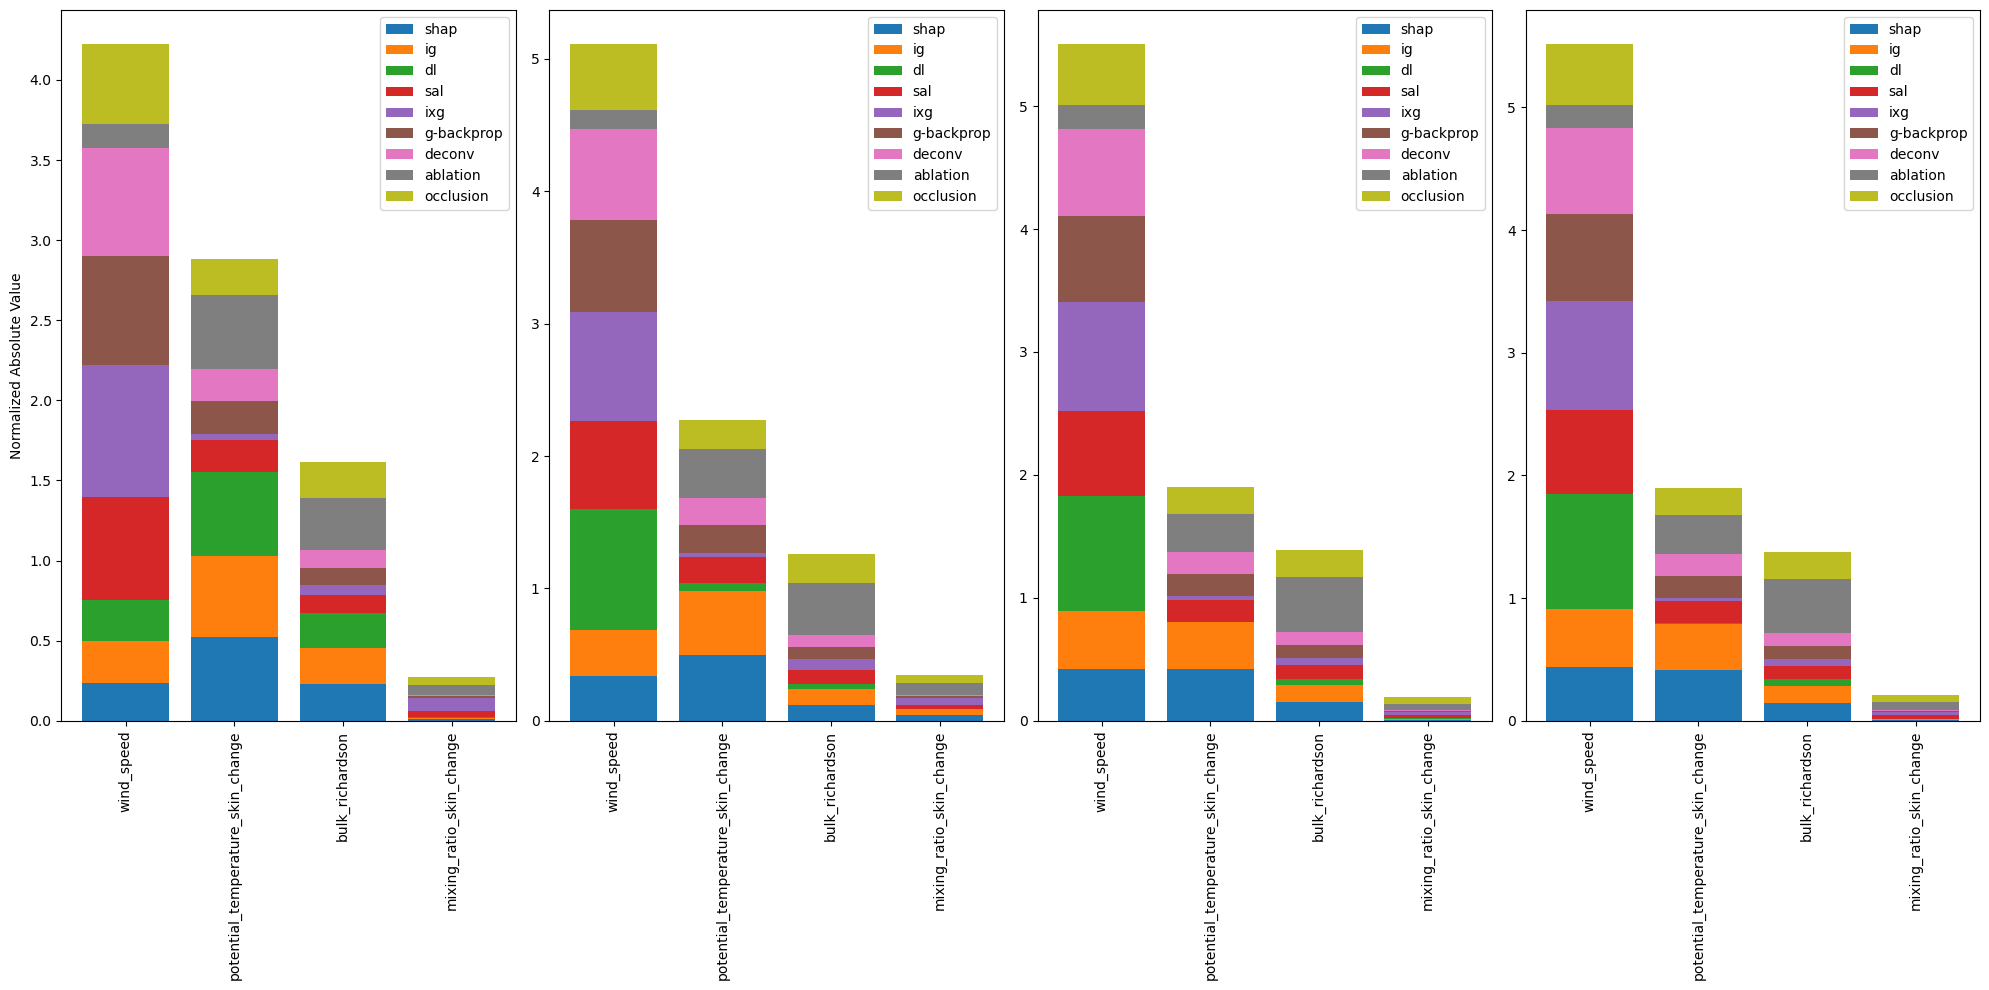

In [50]:
import matplotlib.pyplot as plt
import numpy as np

######################################################

# Normalize each dictionary within reduced_data
for method in reduced_data:
    method_data = reduced_data[method]
    for param in method_data:
        abs_values = np.abs(method_data[param])
        sum_abs_values = abs_values.sum()
        normalized_values = abs_values / sum_abs_values
        reduced_data[method][param] = normalized_values

# Sum over dictionaries and then over arrays
summed_values = {}
for param in reduced_data['ablation']:  # Assuming both methods have the same parameters
    summed_values[param] = np.zeros(4)  # Initialize an array to store summed values
    for method in reduced_data:
        summed_values[param] += np.abs(reduced_data[method][param])

######################################################

# Create a single figure with four subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

# Plot stacked bar charts
categories = list(reduced_data.keys())
parameters = list(reduced_data[categories[0]].keys())
x = conf['data']['input_cols']  # 4 data points for each parameter

for i, param in enumerate(parameters):
    ax = axs[i]
    
    # Take absolute values and normalize
    abs_values = {cat: np.abs(reduced_data[cat][param]) for cat in categories}
    for c, v in abs_values.items():
        abs_values[c] = v / sum(v)
    
    # Get the order based on summed_values
    order = np.argsort(summed_values[param])[::-1]  # Sort in descending order
    
    # Reorder data according to the sorted indices
    x_sorted = np.arange(len(order))
    abs_values_sorted = {cat: abs_values[cat][order] for cat in categories}
    
    bottom = np.zeros(len(order))
    for category in categories:
        ax.bar(x_sorted, abs_values_sorted[category], bottom=bottom, label=category)
        bottom += abs_values_sorted[category]
    
    #ax.set_title(param)
    ax.set_xticks(x_sorted)
    ax.set_xticklabels([x[o].split(":")[0] for o in order], rotation = 90, ha='center', fontsize = 10)
    ax.legend()
    
    if i == 0:
        ax.set_ylabel('Normalized Absolute Value')

plt.tight_layout()
plt.show()